# Static Portfolio

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Notas personales

$$
CVaR_w (\alpha) = -E[r_w \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
C_{(i)}CVaR_w (\alpha) = -E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
\%C_{(i)}CVaR_w(\alpha) = \frac{E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w(\alpha)]}{E[r_w \ | \ r_w \leq -VaR_w(\alpha)]}
$$

MCC portfolio:

$$
w^{MCC} = argmin \ C_w (\alpha)
$$

$$
\ \ w \in W
$$

where

$$
C_w(\alpha) = max_i \ C_{(i)}CVaR_w (\alpha)
$$

The other two strategies are the minimum CVaR (MC) and equal-weight (EW) portfolios:

$$
w^{minCVaR} = argmin_{w \in W}CVaR_w (\alpha) \ \text{and} \ w^{EW} = (1/N, ... , 1/N)'
$$

## Download data

In [12]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
start_date = '2019-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start_date, end_date)['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

# defining alpha and the number of assets
alpha = 0.05
n_assets = len(returns.columns)

[*********************100%***********************]  4 of 4 completed


## Calculate CVaR

In [13]:
# CVaR for only long positions
def portfolio_return(weights):
    return np.dot(returns, weights)

# Better way to calculate CVaR than the one used in my homework 1. I used .query in the homework, but checking with friends this way is better.
def cvar(portfolio_returns, alpha):
    var = np.percentile(portfolio_returns, alpha*100)
    cvar = -portfolio_returns[portfolio_returns < var].mean()
    return cvar

def individual_cvar_contributions(weights, returns, alpha):
    portfolio_returns = portfolio_return(weights)
    var = np.percentile(portfolio_returns, alpha*100)

    # check which days are in the cvar for the portfolio
    bad_days_portfolio = portfolio_returns < var

    contributions = []
    # chech the returns of each asset the days where the portfolio is in the cvar to know the contribution
    for i in range(n_assets):
        asset_contribution = -returns.iloc[:, i][bad_days_portfolio].mean() * weights[i]
        contributions.append(asset_contribution)
    
    portfolio_cvar = cvar(portfolio_returns, alpha)

    percentage_contributions = []
    for j in range(len(contributions)):
        pct_contributions = contributions[j] / portfolio_cvar
        percentage_contributions.append(pct_contributions)
    
    return contributions

## Optimization

In [14]:
def optimal_mcc(weights, returns, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights = result.x



def min_cvar(weights, returns, alpha):
    portfolio_returns = portfolio_return(weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights = result_min_cvar.x


## Results

In [15]:
mcc_cvar_contrubutions = individual_cvar_contributions(mcc_weights, returns, alpha)
mcc_cvar = cvar(portfolio_return(mcc_weights), alpha)
mcc_cvar_pct_contributions = mcc_cvar_contrubutions / mcc_cvar

min_cvar_cvar_contrubutions = individual_cvar_contributions(min_cvar_weights, returns, alpha)
min_cvar_cvar = cvar(portfolio_return(min_cvar_weights), alpha)
min_cvar_cvar_pct_contributions = min_cvar_cvar_contrubutions / min_cvar_cvar

ew_weights = np.ones(n_assets) / n_assets
ew_cvar_contrubutions = individual_cvar_contributions(ew_weights, returns, alpha)
ew_cvar = cvar(portfolio_return(ew_weights), alpha)
ew_cvar_pct_contributions = ew_cvar_contrubutions / ew_cvar

In [16]:
print(f'MCC Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_weights[i]:.3%}')
print('---------------------')

print()

print(f'MCC Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_cvar_pct_contributions[i]:.3%}')
print('---------------------')

print()
print()

print(f'Min CVaR Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_weights[i]:.3%}')
print('---------------------')

print()

print(f'Min CVaR Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_cvar_pct_contributions[i]:.3%}')
print('---------------------')

print()
print()

print(f'Equal-Weight Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_weights[i]:.3%}')
print('---------------------')

print()

print(f'Equal-Weight Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_cvar_pct_contributions[i]:.3%}')
print('---------------------')

MCC Portfolio weights:
---------------------
GSG: 12.094%
VBTLX: 66.011%
VNQ: 10.182%
VTI: 11.713%
---------------------

MCC Portfolio CVaR percentage contribution:
---------------------
GSG: 25.518%
VBTLX: 25.379%
VNQ: 25.507%
VTI: 23.596%
---------------------


Min CVaR Portfolio weights:
---------------------
GSG: 3.740%
VBTLX: 95.629%
VNQ: 0.000%
VTI: 0.631%
---------------------

Min CVaR Portfolio CVaR percentage contribution:
---------------------
GSG: 3.752%
VBTLX: 95.614%
VNQ: 0.000%
VTI: 0.633%
---------------------


Equal-Weight Portfolio weights:
---------------------
GSG: 25.000%
VBTLX: 25.000%
VNQ: 25.000%
VTI: 25.000%
---------------------

Equal-Weight Portfolio CVaR percentage contribution:
---------------------
GSG: 32.878%
VBTLX: 0.759%
VNQ: 35.476%
VTI: 30.888%
---------------------


## Backtesting

In [17]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
data = yf.download(tickers, end_date, end='2024-12-31')['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


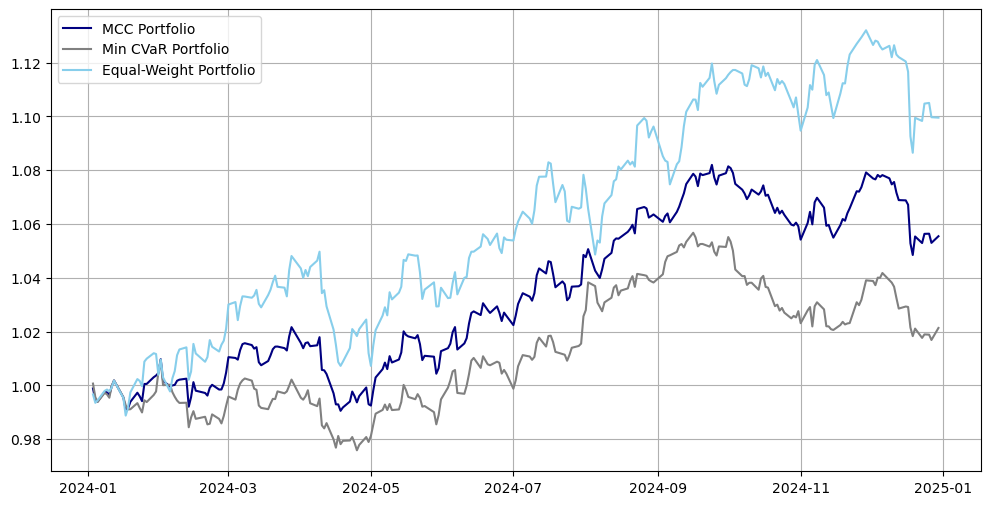

In [18]:
mcc_portfolio_returns = portfolio_return(mcc_weights)
cumulative_return_mcc_port = (1 + mcc_portfolio_returns).cumprod()

min_cvar_portfolio_returns = portfolio_return(min_cvar_weights)
cumulative_return_min_cvar_port = (1 + min_cvar_portfolio_returns).cumprod()

ew_portfolio_returns = portfolio_return(ew_weights)
cumulative_return_ew_port = (1 + ew_portfolio_returns).cumprod()

cumulative_returns_df = pd.DataFrame({
    'MCC Portfolio': cumulative_return_mcc_port,
    'Min CVaR Portfolio': cumulative_return_min_cvar_port,
    'Equal-Weight Portfolio': cumulative_return_ew_port
})
cumulative_returns_df.index = returns.index

plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_df['MCC Portfolio'], label='MCC Portfolio', c = 'navy')
plt.plot(cumulative_returns_df['Min CVaR Portfolio'], label='Min CVaR Portfolio', c = 'gray')
plt.plot(cumulative_returns_df['Equal-Weight Portfolio'], label='Equal-Weight Portfolio', c = 'skyblue')

plt.legend()
plt.grid();

In [19]:
returns_df = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns,
    'Min CVaR Portfolio': min_cvar_portfolio_returns,
    'Equal-Weight Portfolio': ew_portfolio_returns
})

summary_df = pd.DataFrame({
    'Return (%)': (cumulative_returns_df.iloc[-1] - 1) * 100,
        'Annualized Volatility (%)': returns_df.std() * np.sqrt(252) * 100
})
summary_df

,Return (%),Annualized Volatility (%)
MCC Portfolio,5.545834,5.431402
Min CVaR Portfolio,2.136495,5.134007
Equal-Weight Portfolio,9.952945,7.896683
